# MAPIE and Conformal Predictions with a LLM.

## Overview

This notebook demonstrates how to use MAPIE for conformal predictions with a Large Language Model (LLM). The goal is to evaluate prediction sets for a multiple-choice question-answering task using conformal prediction techniques. This notebook is based on the work presented in [Benchmarking LLMs via Uncertainty Quantification](https://arxiv.org/abs/2401.12794). Parts of the code come from this [Github repo](https://github.com/smartyfh/LLM-Uncertainty-Bench). 

To be able to use conformal predictions, we reduce our problem to a classification task: we only take the logits corresponding to the possible answers, and use a softmax so that the LLM can be used as a simple classifier.

## Key Components

- **Dataset**: The CosmosQA dataset, a benchmark for commonsense reasoning.
- **LLM**: The notebook utilizes the `Mistral-7B-Instruct-v0.3` model for predictions.
- **MAPIE for Conformal Prediction**: The `SplitConformalClassifier` from MAPIE is used to generate prediction sets with a given confidence level.

## Steps Covered

1. **Setup & Installation**
   - Clone the repository and install required dependencies.
   - Authenticate with Hugging Face Hub to access the LLM.

2. **Data Preprocessing**
   - Load and transform CosmosQA data into a format suitable for the model.

3. **Model Loading**
   - Load the `Mistral-7B` model and its tokenizer.
   - Define an `LLMClassifier` wrapper to make predictions in a structured format.

4. **Conformal Prediction with MAPIE**
   - Use `SplitConformalClassifier` to calibrate the model on a subset of the data.
   - Generate prediction sets with a 95% confidence level.

5. **Evaluation & Visualization**
   - Compute accuracy scores and coverage metrics.
   - Visualize the size distribution of prediction sets.
   - Plot accuracy per prediction set size.

## Results

- The LLM achieves an accuracy of approximately **86%** on the test set.
- Prediction sets provide calibrated uncertainty estimates, enhancing reliability in decision-making.
- The more uncertain the model is (i.e., the larger the prediction sets), the lower the accuracy.

## Conclusion

This notebook illustrates how conformal prediction techniques can be applied to LLMs for more trustworthy AI systems. The approach can be extended to other question-answering datasets and models to assess confidence in model predictions.



# First step : install and import dependencies

In [1]:
!rm -rf /content/mapie_llm
!git clone https://github.com/gmartinonQM/mapie_llm

Cloning into 'mapie_llm'...
remote: Enumerating objects: 128, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 128 (delta 68), reused 46 (delta 15), pack-reused 0 (from 0)
Receiving objects: 100% (128/128), 2.58 MiB | 5.87 MiB/s, done.
Resolving deltas: 100% (68/68), done.


In [2]:
!pip install mapie

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 kB 4.1 MB/s eta 0:00:00


In [3]:
import json
import sys

sys.path.append('/content/mapie_llm')

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from google.colab import userdata
from huggingface_hub import login
from mapie.classification import SplitConformalClassifier
from mapie.metrics.classification import (
    classification_coverage_score,
    classification_mean_width_score,
)
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer

from utils.cosmosqa import TransformCosmosQA


Do not forget to register your HuggingFace token in your colab secrets, and make it visible to this notebook.

In [4]:
login(token=userdata.get("HF_TOKEN"))

# Notebook parameters
We retain `N_OBS` CosmosQA examples to conformalize and evaluate our LLM. `CONFIDENCE_LEVEL` drives the size of the prediction sets we will output for each answer.

In [5]:
N_OBS = 1000
CONFIDENCE_LEVEL = 0.95

# Load data and transform it to X, y (X being a prompt)

The prompts are composed of:
- Fewshot examples (questions with answers)
- Context
- Question regarding the context

Labels are one-hot encoded (i.e. labels are 0, 1, 2 or 3). In the prompts, two more labels are proposed ("None of the above" and "I don't know"). As the model never outputs these answers in practise, we chose to discard them.

In [6]:
data = json.load(open("/content/mapie_llm/cosmosqa_10k.json"))

We observe that the dataset contains 10 thousands questions with their context and answer.

In [7]:
len(data)

10000

Here is what an example looks like.

In [8]:
data[3]

{'source': 'CosmosQA',
 'task': 'commonsense-based reading comprehension',
 'context': "My house is constantly getting messy and I ca n't keep up . I am starting at a new school with no one I know and it is 4 times bigger than UAF . I am now going to have to balance school , homework , kids , bill paying , appointment making and cleaning when I can barely keep up without the school and homework ( keep in mind this is a full time GRADUATE program at a fairly prestigious school ) . We are in financial crisis .",
 'question': "What is causing the narrator 's recent stress ?",
 'choices': {'A': 'They are moving to a new house .',
  'B': 'I would have tried to guess their password and alternatively gone to a coffee shop for wifi',
  'C': 'They are moving to a new university .',
  'D': 'They are moving to a new house for the kids .',
  'E': "I don't know",
  'F': 'None of the above'},
 'answer': 'C',
 'id': 3}

Now we format all these examples into nicely formatted questions to be answered by the LLM (`X`), together with the ground truth (`y`). We add 5 few-shot examples on top of each question, as well as some instructions.

In [9]:
data_transformer = TransformCosmosQA(data)
X, y = data_transformer.transform_data()

Here is what our previous example now looks like.

In [10]:
print(X[3])


The following is a multiple-choice question about reading comprehension.
You should answer the question based on the given context and you can use
commonsense reasoning when necessary. Please reason step-by-step and select
the correct answer. You only need to output the option.


Context: It 's got character . You know what they say : ' If it ai n't too broke , do n't fix it ' . " Howard stood up in his pyjamas that smelled of Vince , and looked out of the window . He repeated Vince 's aphorism over and over until his heartbeat settled a little .
Question: What was Howard doing when he walked to the window
Choices:
A. He was sneezing
B. He was chewing gum
C. He was scratching his lap
D. He was thinking
E. I don't know
F. None of the above
Answer: D
Context: My house is constantly getting messy and I ca n't keep up . I am starting at a new school with no one I know and it is 4 times bigger than UAF . I am now going to have to balance school , homework , kids , bill paying , appointment

As for the ground truth, it has been label encoded to integers.

In [11]:
print(y[3])

2


For the rest of this notebook, we only use a subset of the whole dataset.

In [12]:
X_small, y_small = X[-N_OBS:], y[-N_OBS:]
print(len(X_small))

1000


Following standard conformal prediction practices, we set aside a conformalization set to conformalize the predictions. This allows us to get valid prediction sets on the testing set.

In [13]:
X_conf, X_test, y_conf, y_test = train_test_split(X_small, y_small, train_size=0.5, random_state=1)
print(len(X_conf))
print(len(X_test))

500
500


# Load the model and its tokenizer

We now download the weights from an open-source LLM. You may need to request access directly on HuggingFace website.

In [14]:
def load_model(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, device_map="auto")
    model.eval()
    return tokenizer, model

tokenizer, model = load_model("mistralai/Mistral-7B-Instruct-v0.3")

# Wrap the model

In order to make the model compatible with MAPIE, it needs to have ```fit```, ```predict_proba``` and ```predict```methods as well as ```is_fitted```and ```classes_``` attributes.

In [15]:
class LLMClassifier:

    def __init__(self, tokenizer, model):
        self.tokenizer = tokenizer
        self.model = model
        self.options = ["Answer: A", "Answer: B", "Answer: C", "Answer: D"]
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.options_ids = [self.tokenizer.encode(opt)[-1] for opt in self.options]
        self.is_fitted_ = True
        self.classes_ = [0, 1, 2, 3]

    def fit(self):
      pass

    def predict_proba(self, prompts):
        if isinstance(prompts, str):
            prompts = [prompts]  # Convert single prompt to list
        pred_probas = []
        for prompt in tqdm(prompts):
            prompt = [prompt]
            inputs = self._prepare_inputs(prompt)
            with torch.no_grad():
                outputs = self.model(**inputs)
            logits = outputs.logits[:, -1, :]  # Extract logits for the last token, [batch_size, vocab_size]
            logits_options = logits[:, self.options_ids]  # Select logits corresponding to answer options
            logits_options = logits_options.type(torch.float32)  # Ensure correct precision during softmax
            probabilities = F.softmax(logits_options, dim=-1).cpu().numpy().flatten()
            probabilities /= probabilities.sum() # Ensure that the sum is exaclty equal to 1, which may not be true in some cases
            pred_probas.append(probabilities)
        return np.array(pred_probas)

    def predict(self, prompts):
        probas = self.predict_proba(prompts)
        return np.argmax(probas, axis=-1)

    def _prepare_inputs(self, prompts):
        inputs = self.tokenizer(prompts, return_tensors="pt", truncation=True)
        for k in inputs:
            if torch.is_tensor(inputs[k]):
                inputs[k] = inputs[k].to("cuda")
        return inputs

In [16]:
llm = LLMClassifier(tokenizer, model)

# Run the LLM with MAPIE

**Exercice 1**: Now that the wrapper has been created, let us determine the prediction sets thanks to MAPIE!
- Call ```SplitConformalClasifier``` with your model and define `CONFIDENCE_LEVEL` as the confidence level.
- Then, call the `conformalize` method with your conformalization set: it will compute the conformity scores and their quantiles. This step may take several minutes.
- Finally, call the `predict_set` method with the test data to output predictions and prediction sets.

In [17]:
scc = SplitConformalClassifier(estimator=llm, confidence_level=CONFIDENCE_LEVEL)  # correction
scc.conformalize(X_conf, y_conf)  # correction
y_pred, y_pred_set = scc.predict_set(X_test)  # correction

100%|██████████| 500/500 [09:44<00:00,  1.17s/it]


And that's it!

Let's have a look at the prediction of our previous example.

In [18]:
truth = y_test[3]
label_int = y_pred[3]
label_str = data_transformer.label_encoder.inverse_transform([label_int])[0]
print(truth)
print(label_int)
print(label_str)

3
3
D


This looks correct ! And what about the prediction set?

In [19]:
y_pred_set[3]

array([[False],
       [False],
       [False],
       [ True]])

The prediction set is an array of boolean, indicating which label is in the set. Here, it turns out that our prediction set is reduced to a singleton. This means that our model is pretty certain of its answer. Let's dive deeper!

# Check the results and visualize the prediction sets

**Exercice 2**: Let's examine how many times did our model find the right answer.
- Compute the accuracy score of the model on the test data.

In [20]:
accuracy = accuracy_score(y_test, y_pred)  # correction

In [21]:
accuracy

0.854

We get an accuracy around 86% on the test set: not bad!

**Exercice 3**: Since we also have prediction sets, a standard metric evaluating their efficiency is the coverage score. It tells us how many times the ground truth did fall into the prediction set. It should match closely our `CONFIDENCE_LEVEL` given to our `SplitConformalClassifier` earlier, since it is a statistical guarantee offered by MAPIE.
- Compute the coverage score of the prediction sets.

In [22]:
coverage = classification_coverage_score(y_test, y_pred_set[:, :, 0])  # correction

In [23]:
coverage

array([0.958])

**Exercice 4**: Last but not least, we would like to evaluate if our prediction sets manage to reach our coverage while being informative, i.e. not being too large. The mean width should thus be much smaller than 4, which is the maximum prediction set size, given there are only 4 choices per question.
- Compute the mean width of the prediction sets.

In [24]:
mean_width = classification_mean_width_score(y_pred_set[:, :, 0])  # correction

In [25]:
mean_width

np.float64(1.536)

These global metrics look good! Now let's look deeper in some examples. The following function picks randomly one example for each prediction set size, from most certain answers (prediction set of size 1) to most uncertain ones (prediction set of size 4).

In [26]:
def print_examples_and_prediction_set(data_transformer, X, y, y_pred, y_pred_set):
  sizes = y_pred_set.sum(axis=1)
  unique_sizes = np.unique(sizes)
  for size in unique_sizes:
    all_idx_size = np.argwhere(sizes == size)[:, 0]  # Indices of all answers having the current prediction set size
    random_idx = np.random.choice(all_idx_size, 1)[0] # Random index among these to use hereafter
    prompt_without_few_shot = X[random_idx].split("Answer:")[-2][3:]  # Retrieve only the question of interest from the prompt
    label = y[random_idx]
    pred = y_pred[random_idx]
    pred_set = np.argwhere(y_pred_set[random_idx][:, 0]).ravel()
    # We need to inverse transform all class numbers to our well-known strings "A", "B", "C" and "D"
    print(
        "==========================================",
        prompt_without_few_shot,
        f"Correct answer: {data_transformer.label_encoder.inverse_transform([label])[0]}",
        f"Prediction: {data_transformer.label_encoder.inverse_transform([pred])[0]}",
        f"Prediction set: {data_transformer.label_encoder.inverse_transform(pred_set)}",
        sep="\n"
    )

In [27]:
print_examples_and_prediction_set(data_transformer, X_test, y_test, y_pred, y_pred_set)

Context: During the two days of the Notting Hill carnival we have seen thousands of people , and I shot hundreds of them . On Sunday I shot a young girl and I had a sort of flashback . I was almost sure I had already seen her ( or to be honest , her hair ) but I did not put a lot of attention to it at the moment . When I went home and I checked the photos I watched the shot carefully and I remember : I had really shot her back in February .
Question: What is most likely to be the speaker 's job ?
Choices:
A. Marksman .
B. Teacher .
C. Photographer .
D. They have alot of work that was completed months ago .
E. I don't know
F. None of the above

Correct answer: C
Prediction: C
Prediction set: ['C']
Context: It 's all over the leaves , and thus , throughout the day , ends up all over my hands and arms . And apparently soap and water does n't get it off so well . Boo - urns to that .
Question: Why did soap and water not get it off so well ?
Choices:
A. Because it 's difficult to get off .


Now that we have inspected some examples with different prediction set sizes, a natural question is how many answers have a given prediction set size? This is what the next function calculates and plots.

In [28]:
def plot_prediction_set_sizes(y_pred_set):
    pred_set_size_per_sample = np.sum(y_pred_set, axis=1)
    min_number = np.min(pred_set_size_per_sample)
    max_number = np.max(pred_set_size_per_sample)
    plt.figure(figsize=(10, 6))
    plt.hist(pred_set_size_per_sample, bins=range(min_number, max_number + 2), align="left", rwidth=0.8)
    plt.title("Distribution of prediction sets sizes")
    plt.xlabel("Prediction set size")
    plt.ylabel("Number of answers")
    plt.xticks(range(min_number, max_number + 1))
    plt.show()


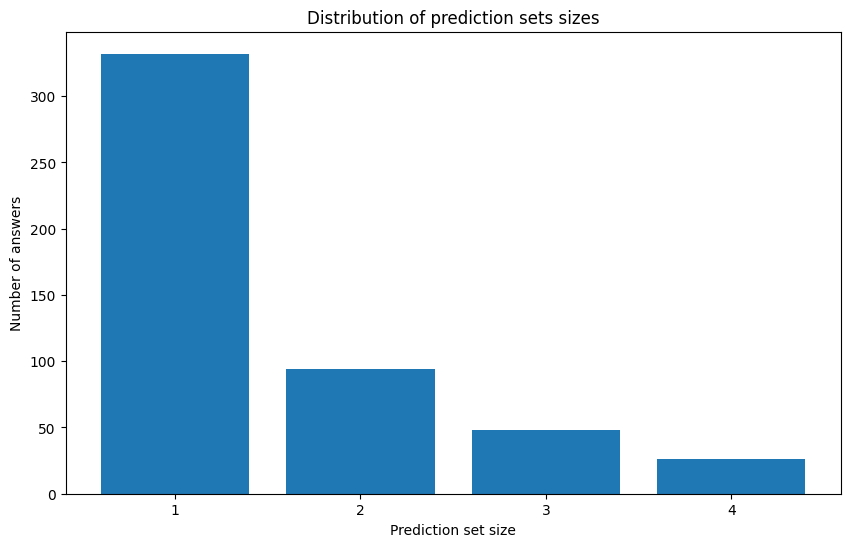

In [29]:
plot_prediction_set_sizes(y_pred_set[:, :, 0])

We see that there is a large majority of singletons, which means that our model is pretty certain on all these answers, good news! Besides, we can now easily spot all the answers for which the model is more uncertain (prediction set size of 2) or completely lost (prediction set of size 3 to 4). Indeed, larger prediction set sizes means larger entropy logits.

At this point, you might wonder: is there a gap in accuracy between answers of different uncertainty? Let's investigate with the following function, that calculates and plots the accuracy for each group of answers, from most certain to most uncertain ones.

In [30]:
def plot_accuracy_per_size(y_test, y_pred_set):
    sizes = y_pred_set.sum(axis=1)
    unique_sizes = np.unique(sizes)
    accuracies = []
    for size in unique_sizes:
        indices = np.where(sizes == size)[0]  # Indices where the prediction set size is equal to the current size
        true_labels = y_test[indices]  # True labels for the current size
        predictions = y_pred[indices]  # Predictions for the current size
        accuracy = accuracy_score(true_labels, predictions)  # Accuracy calculation for the current size
        print(f"Prediction set size: {size} - Accuracy: {accuracy:.2f} - Number of answers: {len(indices)}")
        accuracies.append(accuracy)

    accuracy_global = accuracy_score(y_test, y_pred)  # Overall accuracy

    plt.figure(figsize=(10, 6))  # Adjust figure size as needed

    # plot horizontal line for global accuracy
    plt.axhline(y=accuracy_global, color='r', linestyle='--', label="Global Accuracy")

    plt.bar(unique_sizes.astype(int), accuracies)
    plt.title("Accuracy for each size of prediction sets")
    plt.xlabel("Size of Prediction Set")
    plt.ylabel("Accuracy")
    plt.xticks(unique_sizes.astype(int)) # set xticks to integers
    plt.show()


Prediction set size: 1 - Accuracy: 0.96 - Number of answers: 332
Prediction set size: 2 - Accuracy: 0.66 - Number of answers: 94
Prediction set size: 3 - Accuracy: 0.62 - Number of answers: 48
Prediction set size: 4 - Accuracy: 0.58 - Number of answers: 26


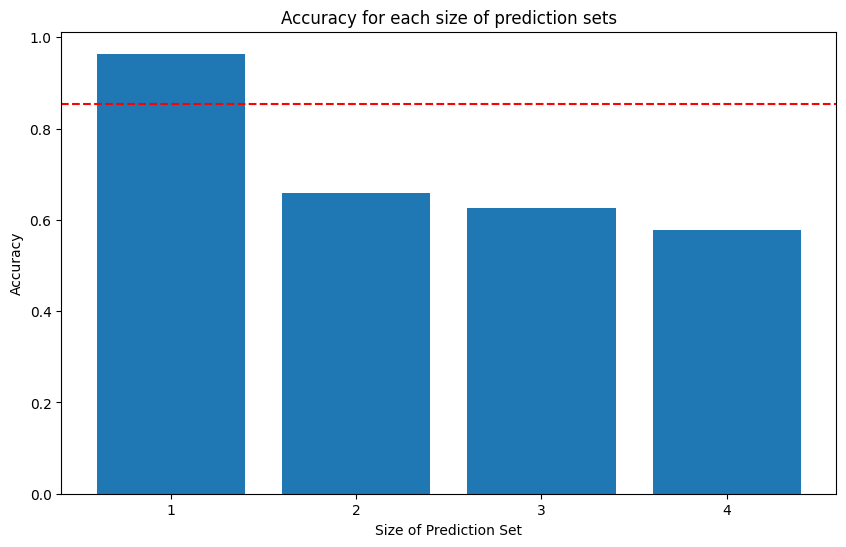

In [31]:
plot_accuracy_per_size(y_test, y_pred_set[:, :, 0])


Interesting! You see that the prediction set size highly correlates with accuracy. In particular, we can separate a high-performing group of almost 350 answers for which the accuracy is no less than 96%! On the other hand, we can directly considers answers with predictions sets sizes of 3-4 as being quite risky, with less than 70% accuracy.

In practice, this means that you can directly treats larger uncertainties answers as higher risks of errors, and thus process them differently (e.g. discarding the answer, warning the user, delegating the answer to a human or a more powerfull LLM, and so on).